## Libraries needed

In [1]:
import pandas as pd
import numpy as np
from numpy import where
import collections
from collections import Counter
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import KFold
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

### In this notebook

We will load, clean, and select all the groups of files that we have collected about household information for Spain from 2015 to 2020. We will be manipulation 3 datasets, one from 2015, another one from 2017 and the third one from 2020.

## 1. Loading the data

In [2]:
df15=pd.read_csv('/Users/mac/Desktop/TFG/data/tables/SPAIN/household/2015/EPFhogar_2015.csv',sep="\t")
df17=pd.read_csv('/Users/mac/Desktop/TFG/data/tables/SPAIN/household/2017/EPFhogar_2017.csv',sep="\t")
df20=pd.read_csv('/Users/mac/Desktop/TFG/data/tables/SPAIN/household/2020/EPFhogar_2020.csv',sep="\t")

/var/folders/vj/crlt_wk5433clrm0qp9q9f3w0000gn/T/ipykernel_14037/3097283021.py:2: DtypeWarning: Columns (96) have mixed types. Specify dtype option on import or set low_memory=False.
  df17=pd.read_csv('/Users/mac/Desktop/TFG/data/tables/SPAIN/household/2017/EPFhogar_2017.csv',sep="\t")


We will only be using the following variables:


TAMANO: Size of the house

NMIEMSD: Number of people who belong to domestic service

UC1: OCDE scale for home size

UC2: OCDE modified scale for home size

ESTUDIOSSP: Completed studies

SITUACTSP: Labour situation

JORNADASP: Type of workday

IMPEXACPSP: Income import

OCUPA: Occupation

SITPROF: Professional situation

SECTOR: Activity sector

TIPOEDIF: Builiding type

ZONARES: Zone type

TIPOCASA: House type

NHABIT: Number of people living in the house

SUPERF: Surface size

NUMOVD: Number of second houses

CAPROP: Income on own account

CAJENA: Income on other accounts

PENSIO: Income from contributory and non-contributory pensions

FUENPRIN: Principal income

In [3]:
#Select the variables which are relevant for the study
var15=df15[['TAMANO','NMIEMSD','UC1','UC2','ESTUDIOSSP','SITUACTSP','JORNADASP','IMPEXACPSP','OCUPA','SITPROF','SECTOR','TIPOEDIF','ZONARES','TIPOCASA','NHABIT','SUPERF','NUMOVD','CAPROP','CAJENA','PENSIO','FUENPRIN']]
var17=df17[['TAMANO','NMIEMSD','UC1','UC2','ESTUDIOSSP','SITUACTSP','JORNADASP','IMPEXACPSP','OCUPA','SITPROF','SECTOR','TIPOEDIF','ZONARES','TIPOCASA','NHABIT','SUPERF','NUMOVD','CAPROP','CAJENA','PENSIO','FUENPRIN']]
var20=df20[['TAMANO','NMIEMSD','UC1','UC2','ESTUDIOSSP','SITUACTSP','JORNADASP','IMPEXACPSP','OCUPA','SITPROF','SECTOR','TIPOEDIF','ZONARES','TIPOCASA','NHABIT','SUPERF','NUMOVD','CAPROP','CAJENA','PENSIO','FUENPRIN']]

## 2. Cleaning of datasets
Now that we have selected the relevant variables for the study, lets clean our data

In [4]:
var15 = var15.replace('  ', pd.NaT)
var15 = var15.fillna(0.0).astype(float)
var17 = var17.replace('  ', pd.NaT)
var17 = var17.fillna(0.0).astype(float)
var20 = var20.replace('  ', pd.NaT)
var20 = var20.fillna(0.0).astype(float)

In [5]:
#Checking for no valuable data
var15.describe()

,TAMANO,NMIEMSD,UC1,UC2,ESTUDIOSSP,SITUACTSP,JORNADASP,IMPEXACPSP,OCUPA,SITPROF,...,TIPOEDIF,ZONARES,TIPOCASA,NHABIT,SUPERF,NUMOVD,CAPROP,CAJENA,PENSIO,FUENPRIN
count,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,...,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000,22011.000000
mean,2.653037,0.001408,2.085121,1.752742,3.908773,2.418427,0.607106,538.620372,5.087184,1.203217,...,3.011494,3.656263,1.941620,5.135569,100.649584,0.180410,5.200854,3.146654,3.852665,2.381082
std,1.212633,0.037503,0.790631,0.545425,1.722091,1.723508,0.567812,819.007495,2.652866,0.591781,...,1.073494,1.531633,0.413097,1.204253,49.111255,0.430894,1.944166,2.557566,2.557660,1.160917
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-9.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,-9.000000,0.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,2.000000,0.000000,1.700000,1.500000,3.000000,1.000000,0.000000,-9.000000,3.000000,1.000000,...,2.000000,3.000000,2.000000,5.000000,73.000000,0.000000,6.000000,1.000000,1.000000,2.000000
50%,2.000000,0.000000,1.700000,1.500000,3.000000,1.000000,1.000000,-9.000000,5.000000,1.000000,...,3.000000,3.000000,2.000000,5.000000,90.000000,0.000000,6.000000,1.000000,6.000000,2.000000
75%,4.000000,0.000000,2.700000,2.100000,5.000000,4.000000,1.000000,1000.000000,7.000000,1.000000,...,4.000000,3.000000,2.000000,6.000000,116.000000,0.000000,6.000000,6.000000,6.000000,3.000000
max,6.000000,1.000000,10.100000,7.100000,8.000000,8.000000,2.000000,12000.000000,9.000000,4.000000,...,5.000000,7.000000,3.000000,8.000000,300.000000,5.000000,6.000000,6.000000,6.000000,7.000000


In [6]:
#Check for null values
var15_null = var15.isnull().sum()
var17_null = var17.isnull().sum()
var20_null = var20.isnull().sum()
print(pd.concat([var15_null, var17_null, var20_null], axis=1, keys=['var15', 'var17', 'var20']))

            var15  var17  var20
TAMANO          0      0      0
NMIEMSD         0      0      0
UC1             0      0      0
UC2             0      0      0
ESTUDIOSSP      0      0      0
SITUACTSP       0      0      0
JORNADASP       0      0      0
IMPEXACPSP      0      0      0
OCUPA           0      0      0
SITPROF         0      0      0
SECTOR          0      0      0
TIPOEDIF        0      0      0
ZONARES         0      0      0
TIPOCASA        0      0      0
NHABIT          0      0      0
SUPERF          0      0      0
NUMOVD          0      0      0
CAPROP          0      0      0
CAJENA          0      0      0
PENSIO          0      0      0
FUENPRIN        0      0      0


In [7]:
#For income missing values, input mean
mean_impexacpsp = var15['IMPEXACPSP'].mean()
var15['IMPEXACPSP'] = var15['IMPEXACPSP'].fillna(mean_impexacpsp)
mean_impexacpsp = var17['IMPEXACPSP'].mean()
var17['IMPEXACPSP'] = var17['IMPEXACPSP'].fillna(mean_impexacpsp)
mean_impexacpsp = var20['IMPEXACPSP'].mean()
var20['IMPEXACPSP'] = var20['IMPEXACPSP'].fillna(mean_impexacpsp)
#For number of second houses, input 0
var15['NUMOVD'] = var15['NUMOVD'].fillna(0)
var17['NUMOVD'] = var17['NUMOVD'].fillna(0)
var20['NUMOVD'] = var20['NUMOVD'].fillna(0)
#Check again
var15_null = var15.isnull().sum()
var17_null = var17.isnull().sum()
var20_null = var20.isnull().sum()
print(pd.concat([var15_null, var17_null, var20_null], axis=1, keys=['var15', 'var17', 'var20']))

            var15  var17  var20
TAMANO          0      0      0
NMIEMSD         0      0      0
UC1             0      0      0
UC2             0      0      0
ESTUDIOSSP      0      0      0
SITUACTSP       0      0      0
JORNADASP       0      0      0
IMPEXACPSP      0      0      0
OCUPA           0      0      0
SITPROF         0      0      0
SECTOR          0      0      0
TIPOEDIF        0      0      0
ZONARES         0      0      0
TIPOCASA        0      0      0
NHABIT          0      0      0
SUPERF          0      0      0
NUMOVD          0      0      0
CAPROP          0      0      0
CAJENA          0      0      0
PENSIO          0      0      0
FUENPRIN        0      0      0


In [8]:
#Check variable data types for later manipulation
var15.dtypes

TAMANO        float64
NMIEMSD       float64
UC1           float64
UC2           float64
ESTUDIOSSP    float64
SITUACTSP     float64
JORNADASP     float64
IMPEXACPSP    float64
OCUPA         float64
SITPROF       float64
SECTOR        float64
TIPOEDIF      float64
ZONARES       float64
TIPOCASA      float64
NHABIT        float64
SUPERF        float64
NUMOVD        float64
CAPROP        float64
CAJENA        float64
PENSIO        float64
FUENPRIN      float64
dtype: object

All our data is valuable

## 3.Data Exploration
We will now explore the correlation of our data per year, dropping those variables with a correlation >0.85

              TAMANO   NMIEMSD       UC1       UC2  ESTUDIOSSP  SITUACTSP  \
TAMANO      1.000000  0.003752  0.982356  0.970370    0.097564  -0.358071   
NMIEMSD     0.003752  1.000000  0.004997  0.005697   -0.003638   0.033057   
UC1         0.982356  0.004997  1.000000  0.997692    0.071699  -0.327471   
UC2         0.970370  0.005697  0.997692  1.000000    0.061093  -0.314791   
ESTUDIOSSP  0.097564 -0.003638  0.071699  0.061093    1.000000  -0.395043   
SITUACTSP  -0.358071  0.033057 -0.327471 -0.314791   -0.395043   1.000000   
JORNADASP   0.301715 -0.029487  0.270453  0.257305    0.346859  -0.856396   
IMPEXACPSP  0.000276 -0.004182 -0.001215 -0.002203    0.124365  -0.006267   
OCUPA       0.052720 -0.018588  0.060550  0.063852   -0.487677  -0.007224   
SITPROF     0.079328 -0.006755  0.082263  0.083962    0.014180  -0.170326   
SECTOR      0.008308 -0.001938  0.002845  0.000022   -0.000701  -0.009876   
TIPOEDIF   -0.073581  0.000726 -0.086530 -0.091731    0.167640  -0.070351   

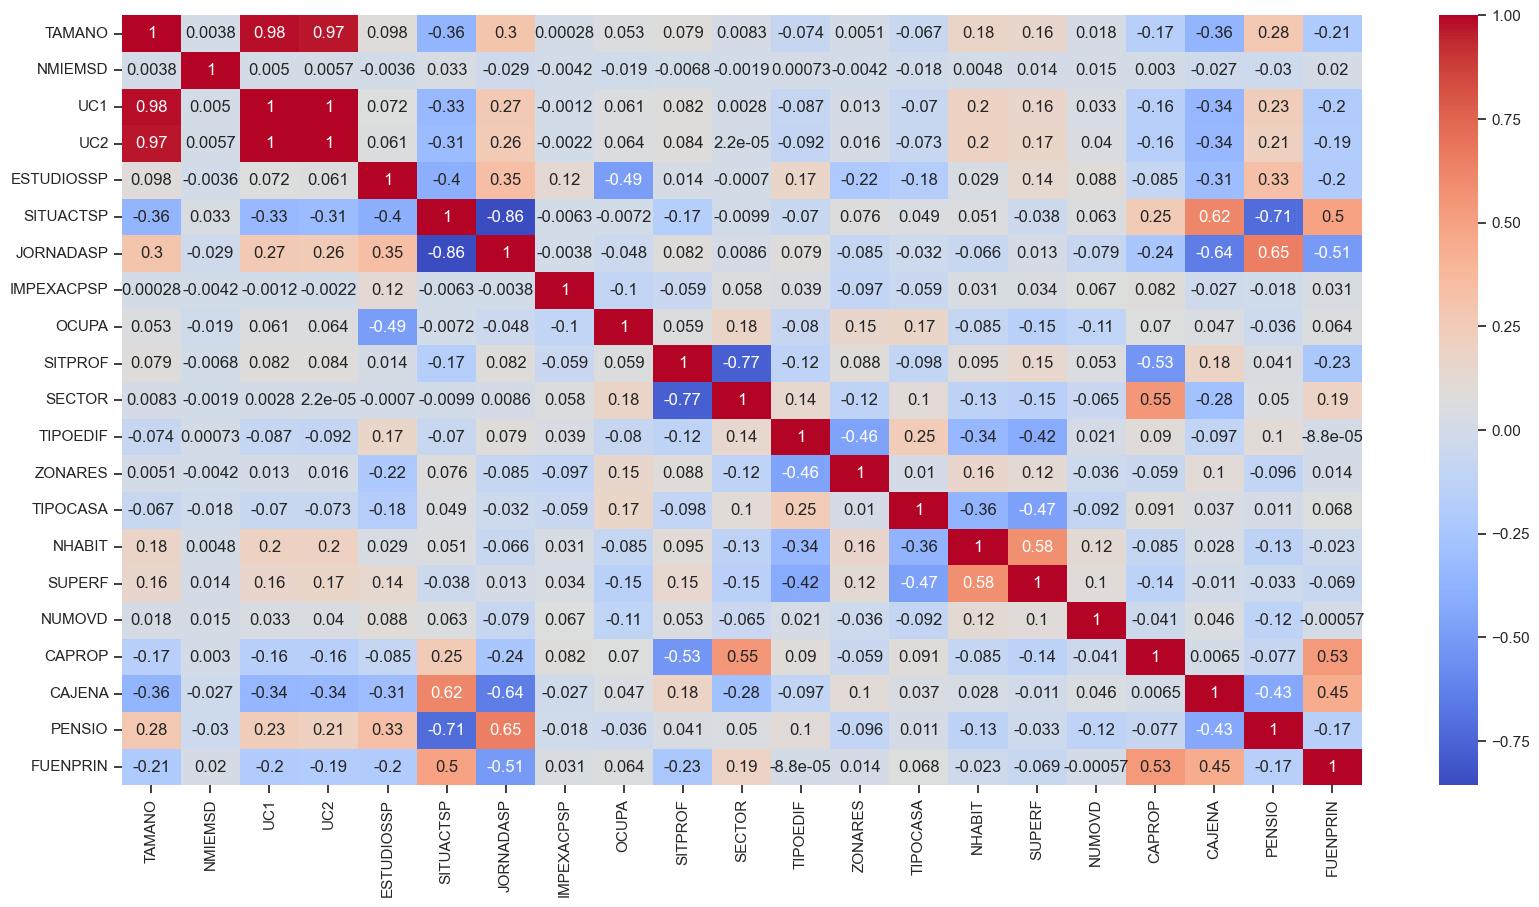

In [9]:
#2015
print(var15.corr())
sns.set(style="ticks")
plt.figure(figsize=(20,10))
sns.heatmap(var15.corr(), annot=True, cmap='coolwarm')
plt.show()

In [10]:
# Drop UC1 and UC2
var15.drop(['UC1','UC2'], axis=1, inplace=True)

              TAMANO   NMIEMSD       UC1       UC2  ESTUDIOSSP  SITUACTSP  \
TAMANO      1.000000  0.002317  0.983193  0.971296    0.096889  -0.367481   
NMIEMSD     0.002317  1.000000  0.004464  0.005552   -0.011811   0.043919   
UC1         0.983193  0.004464  1.000000  0.997727    0.072404  -0.338458   
UC2         0.971296  0.005552  0.997727  1.000000    0.062962  -0.326299   
ESTUDIOSSP  0.096889 -0.011811  0.072404  0.062962    1.000000  -0.385098   
SITUACTSP  -0.367481  0.043919 -0.338458 -0.326299   -0.385098   1.000000   
JORNADASP   0.318147 -0.030251  0.288328  0.275694    0.342026  -0.861510   
IMPEXACPSP  0.005518  0.000407  0.004914  0.005003    0.118517  -0.005255   
OCUPA       0.053606 -0.023309  0.061132  0.063754   -0.493960  -0.016327   
SITPROF     0.079721 -0.004220  0.082082  0.083488    0.014100  -0.178578   
SECTOR      0.003606 -0.017752 -0.002179 -0.004824   -0.006315  -0.002771   
TIPOEDIF   -0.062453 -0.009702 -0.073071 -0.077427    0.171607  -0.066185   

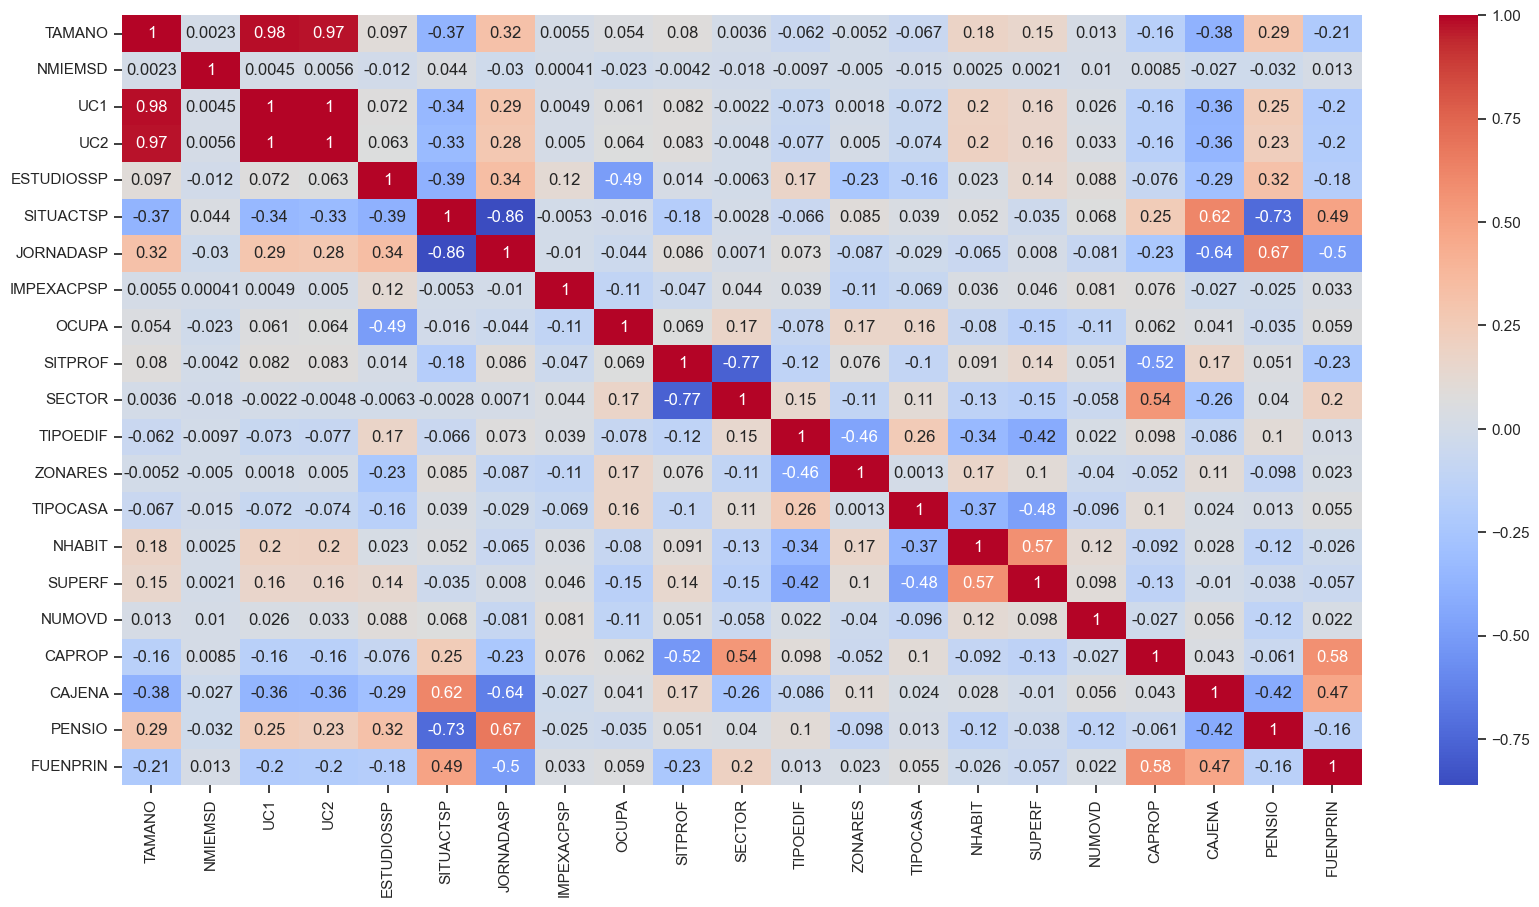

In [11]:
#2017
print(var17.corr())
sns.set(style="ticks")
plt.figure(figsize=(20,10))
sns.heatmap(var17.corr(), annot=True, cmap='coolwarm')
plt.show()

In [12]:
# Drop UC1 and UC2
var17.drop(['UC1','UC2'], axis=1, inplace=True)

              TAMANO   NMIEMSD       UC1       UC2  ESTUDIOSSP  SITUACTSP  \
TAMANO      1.000000  0.019708  0.984986  0.973114    0.119360  -0.354538   
NMIEMSD     0.019708  1.000000  0.023941  0.024565    0.002859   0.024177   
UC1         0.984986  0.023941  1.000000  0.997763    0.096955  -0.329394   
UC2         0.973114  0.024565  0.997763  1.000000    0.088102  -0.318021   
ESTUDIOSSP  0.119360  0.002859  0.096955  0.088102    1.000000  -0.381496   
SITUACTSP  -0.354538  0.024177 -0.329394 -0.318021   -0.381496   1.000000   
JORNADASP   0.321650 -0.015326  0.295045  0.282900    0.340713  -0.860354   
IMPEXACPSP  0.014810 -0.008409  0.014088  0.013845    0.111982  -0.027584   
OCUPA       0.031060 -0.026534  0.039413  0.042879   -0.519118   0.013294   
SITPROF     0.071375  0.007856  0.077386  0.079827    0.004715  -0.144615   
SECTOR      0.011980 -0.017256  0.004504  0.001146   -0.004756  -0.011470   
TIPOEDIF   -0.066039 -0.001363 -0.074905 -0.078607    0.154195  -0.051011   

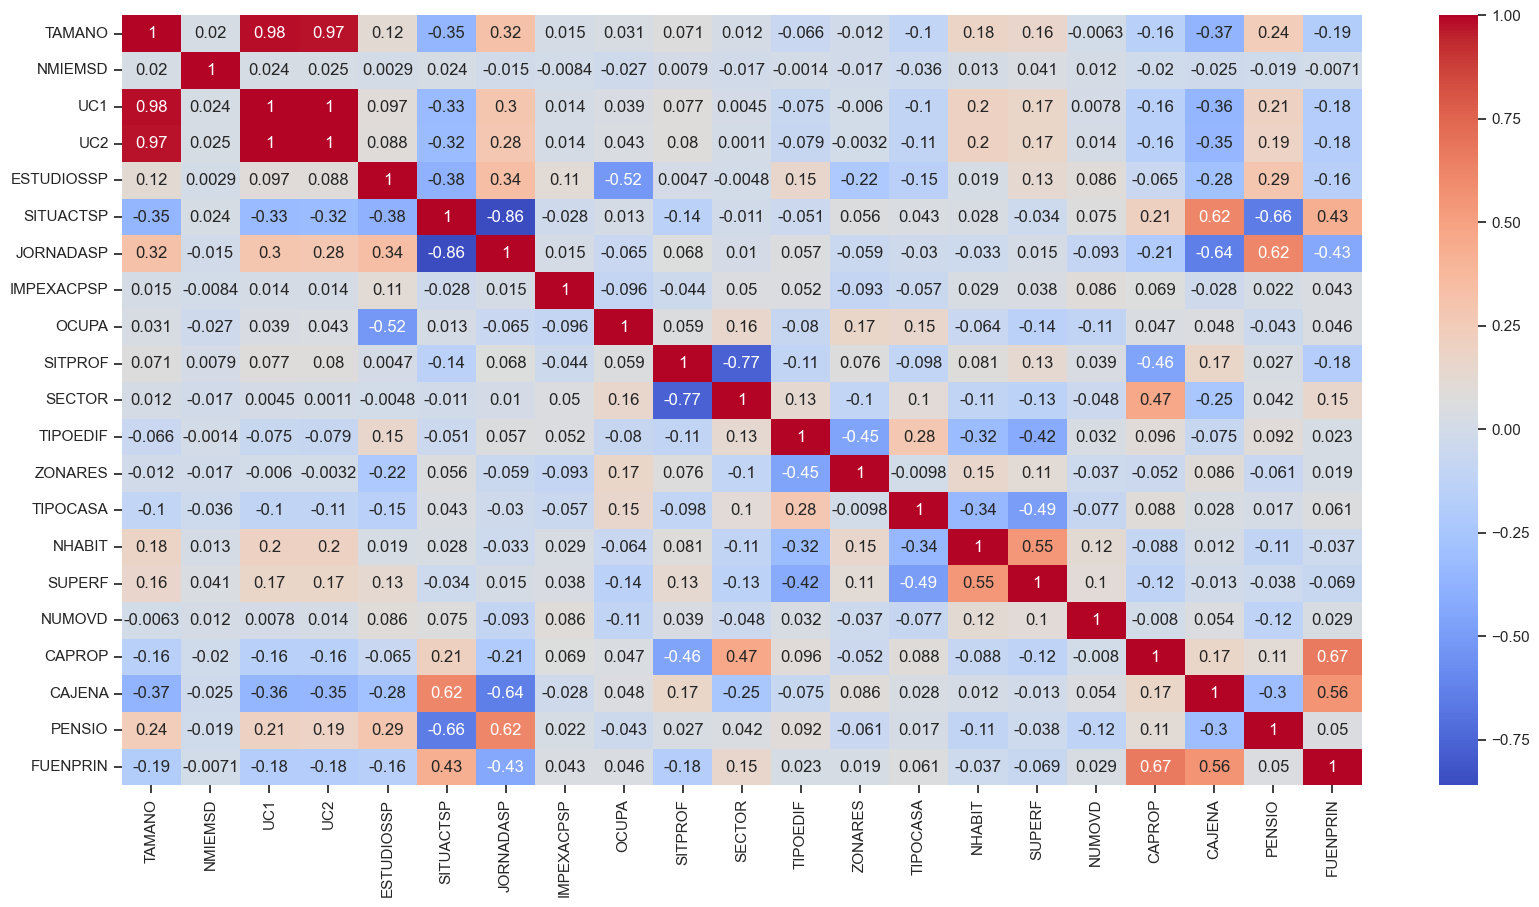

In [13]:
#2020
print(var20.corr())
sns.set(style="ticks")
plt.figure(figsize=(20,10))
sns.heatmap(var20.corr(), annot=True, cmap='coolwarm')
plt.show()

In [14]:
# Drop UC1 and UC2
var20.drop(['UC1','UC2'], axis=1, inplace=True)

Now we will look for outliers in our 3 datasets and eliminate them

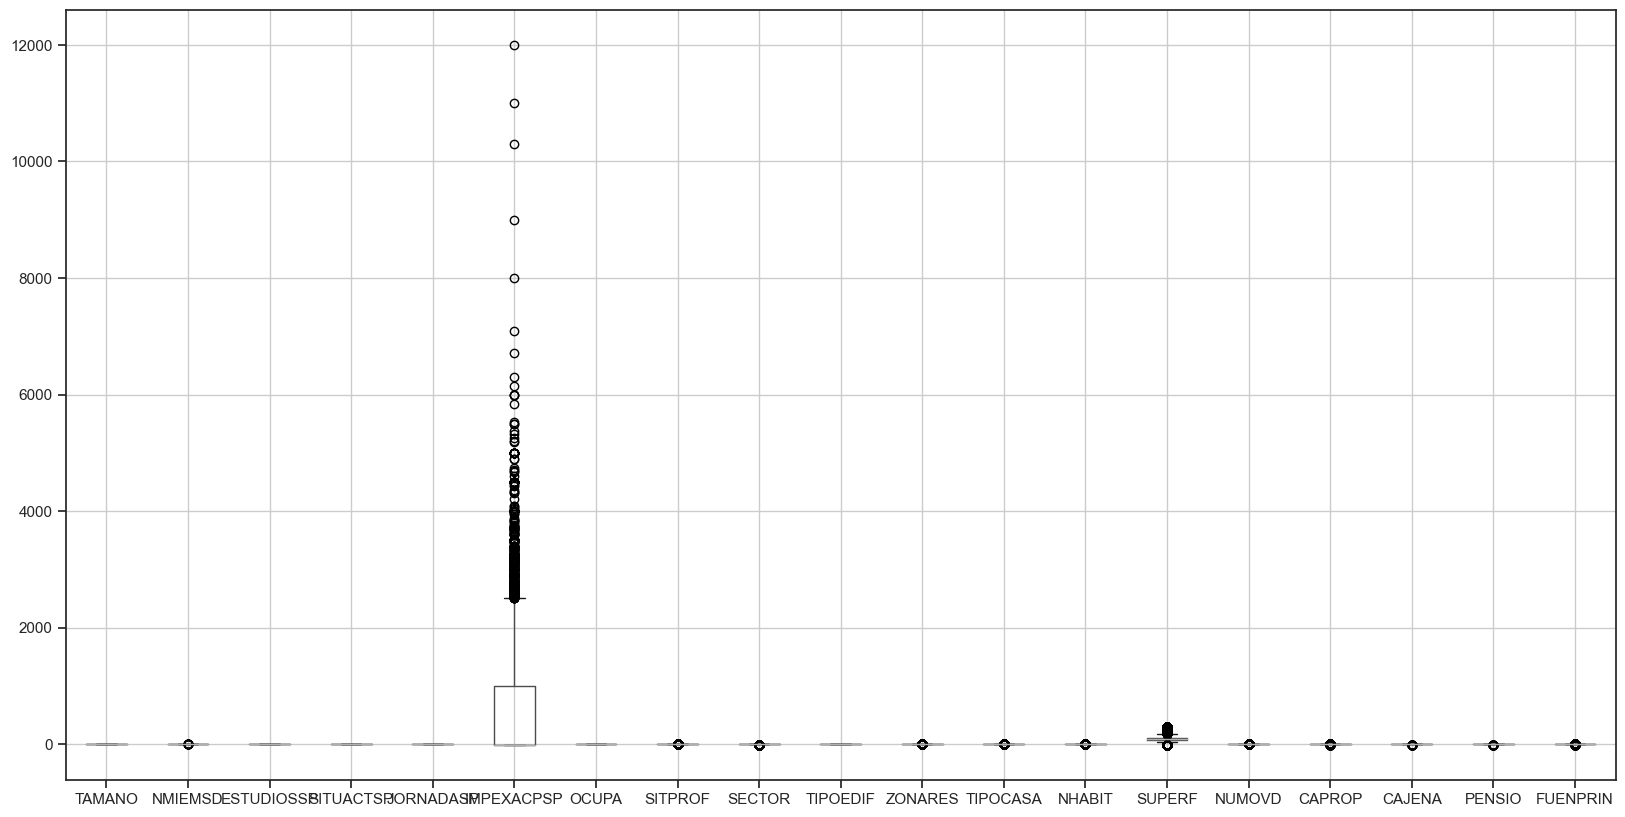

In [15]:
#2015
var15.boxplot(figsize=(20,10))
plt.show()

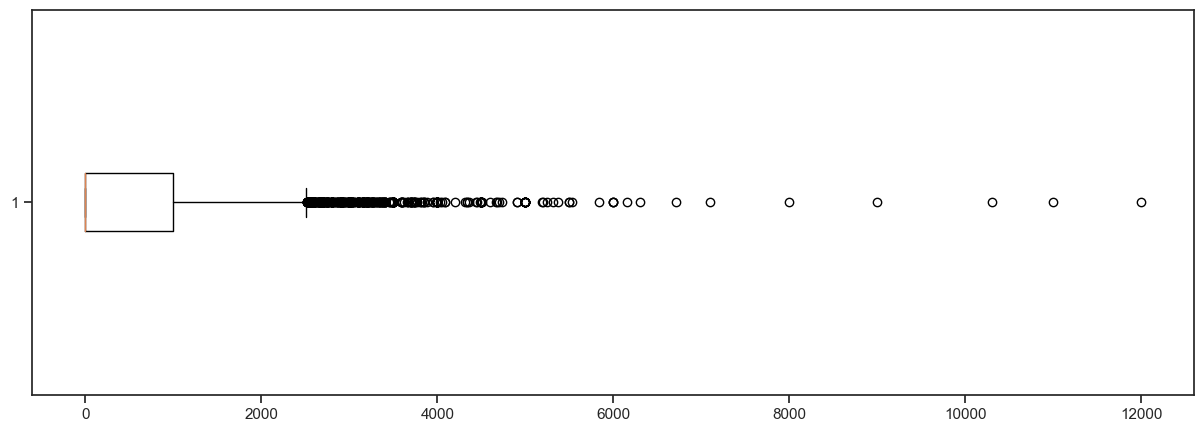

In [16]:
#Have a closer look at dropped variables
plt.boxplot(var15['IMPEXACPSP'],vert=False)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

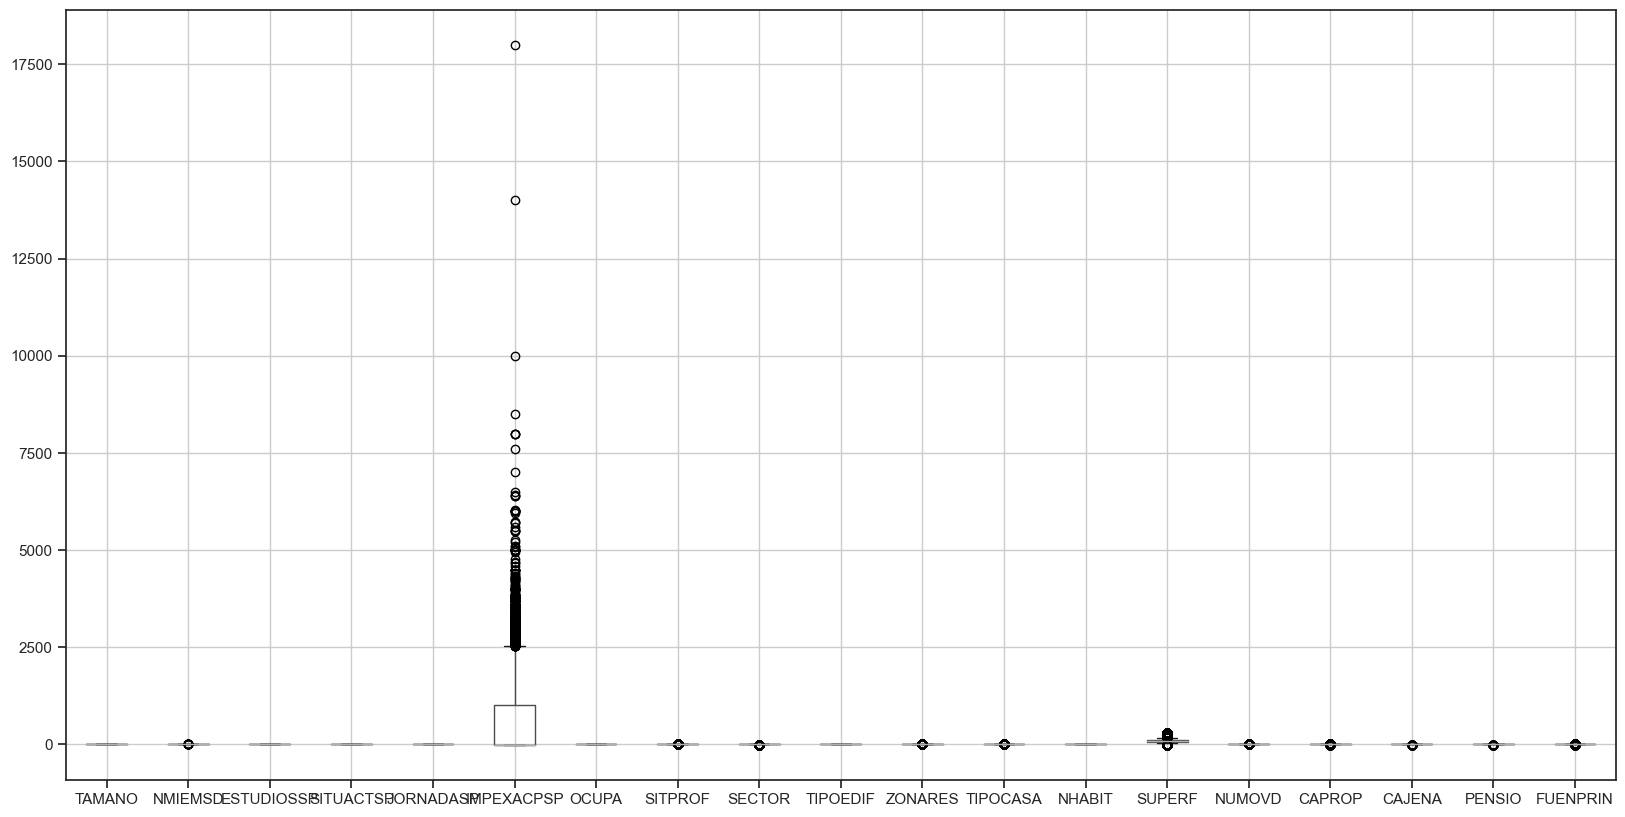

In [17]:
#2017
var17.boxplot(figsize=(20,10))
plt.show()

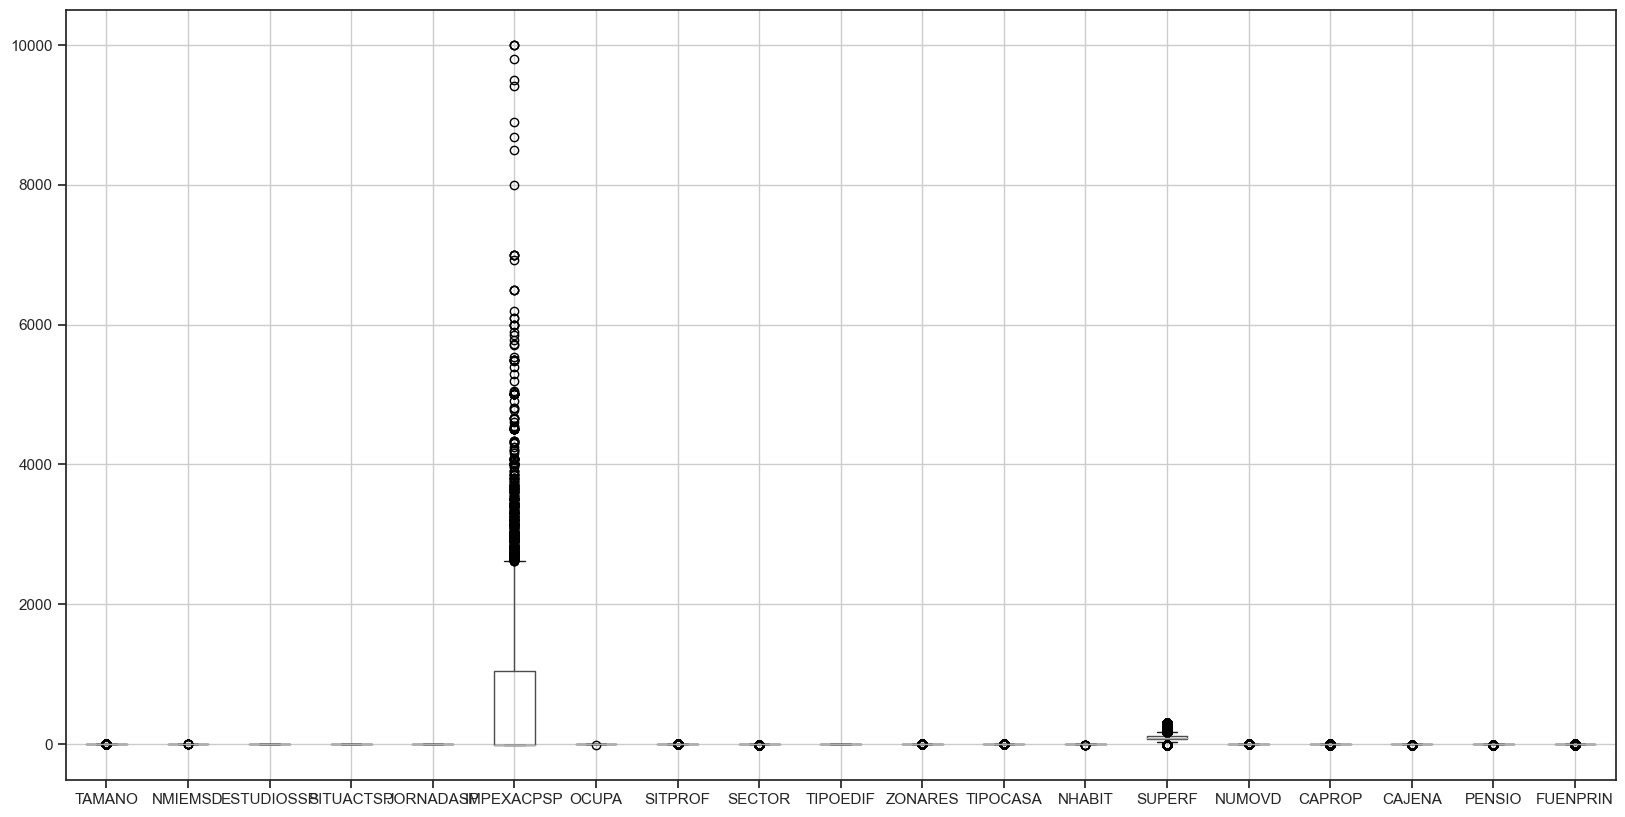

In [18]:
#2020
var20.boxplot(figsize=(20,10))
plt.show()

Remove variables with much larger variation to properly look at the data

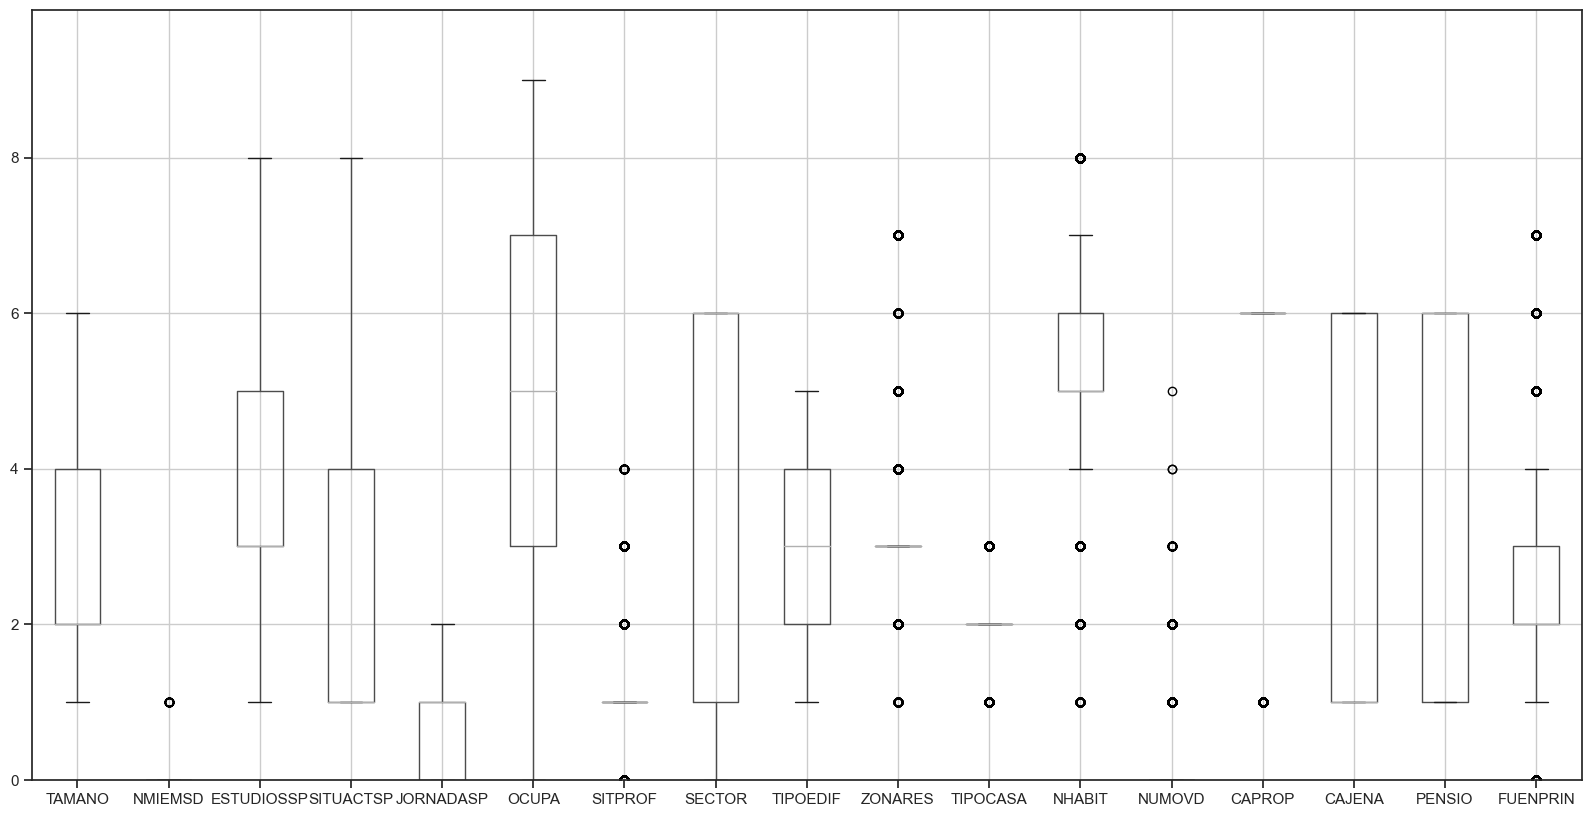

In [19]:
#2015
box=var15.drop(['IMPEXACPSP','SUPERF'],axis=1)
box.boxplot(figsize=(20,10))
plt.ylim(0, None)
plt.show()

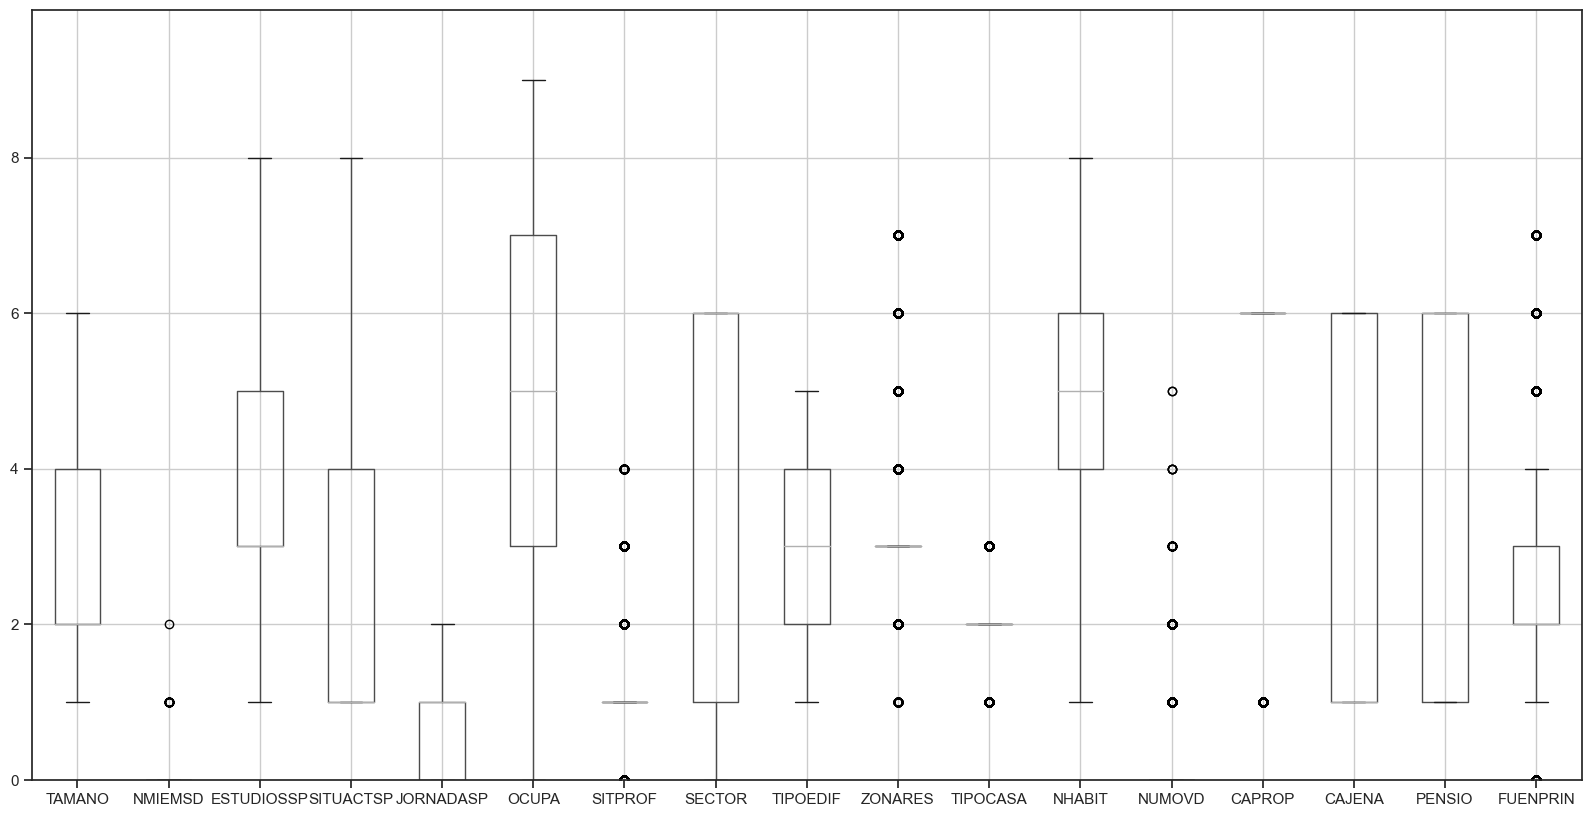

In [20]:
#2017
box=var17.drop(['IMPEXACPSP','SUPERF'],axis=1)
box.boxplot(figsize=(20,10))
plt.ylim(0, None)
plt.show()

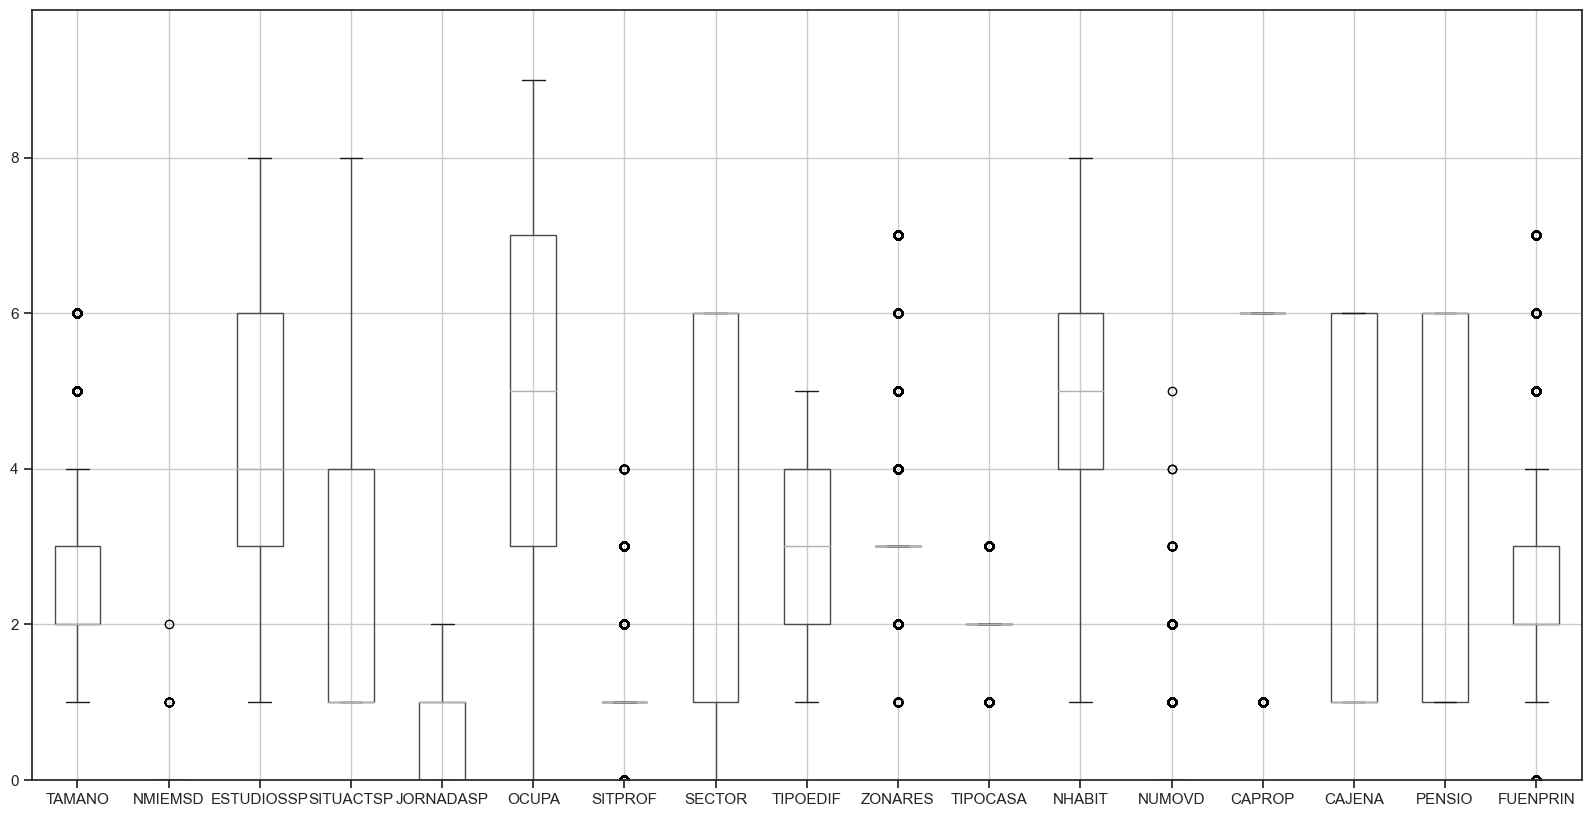

In [21]:
#2020
box=var20.drop(['IMPEXACPSP','SUPERF'],axis=1)
box.boxplot(figsize=(20,10))
plt.ylim(0, None)
plt.show()

Have a closer look at dropped variables

2015

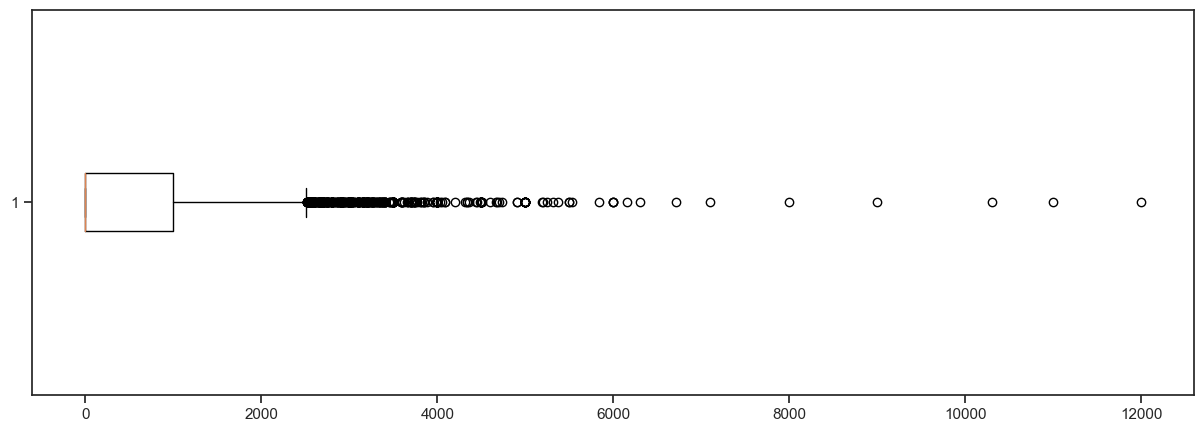

In [22]:
plt.boxplot(var15['IMPEXACPSP'],vert=False)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

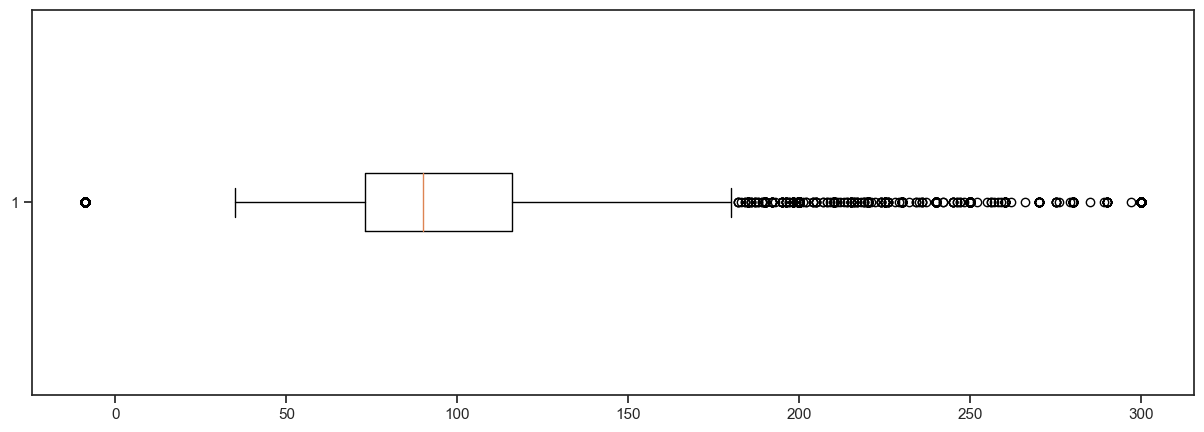

In [23]:
plt.boxplot(var15['SUPERF'],vert=False)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

2017

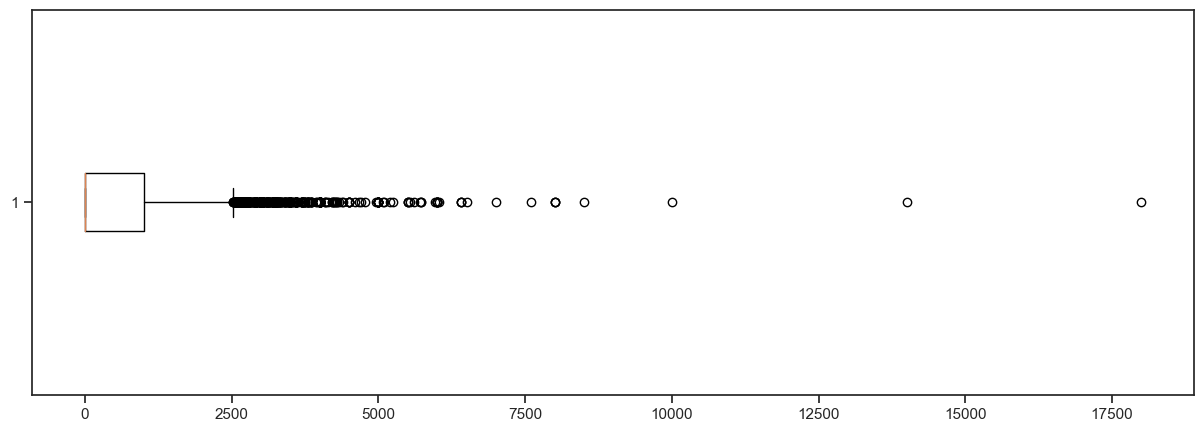

In [24]:
plt.boxplot(var17['IMPEXACPSP'],vert=False)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

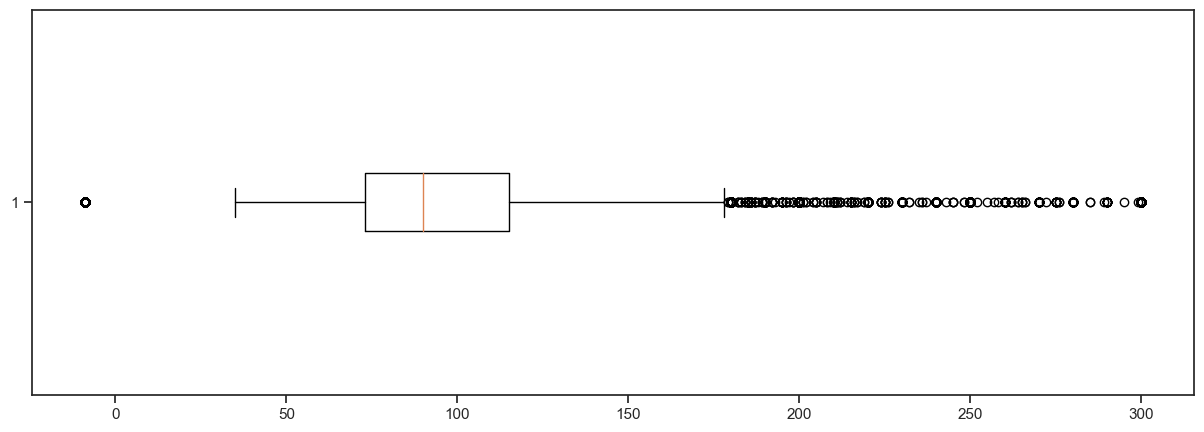

In [25]:
plt.boxplot(var17['SUPERF'],vert=False)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

2020

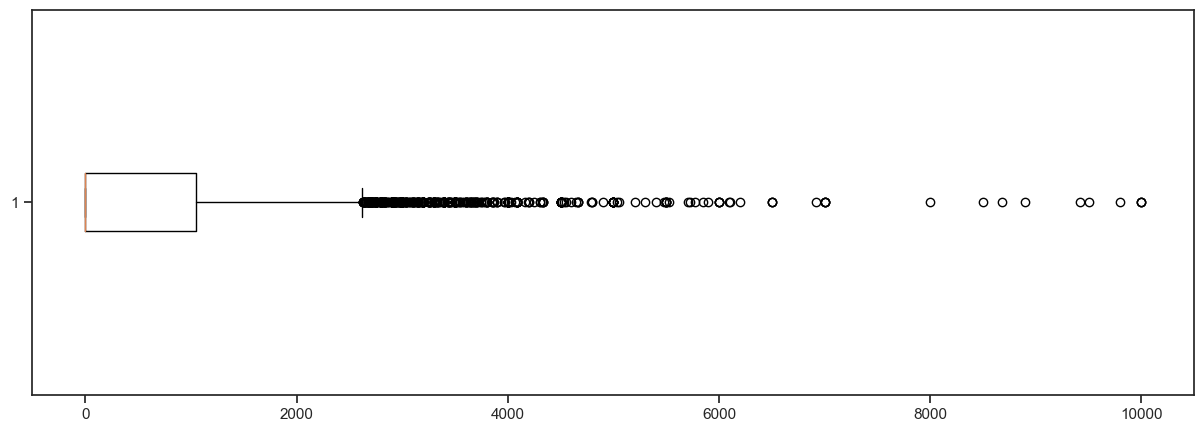

In [26]:
plt.boxplot(var20['IMPEXACPSP'],vert=False)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

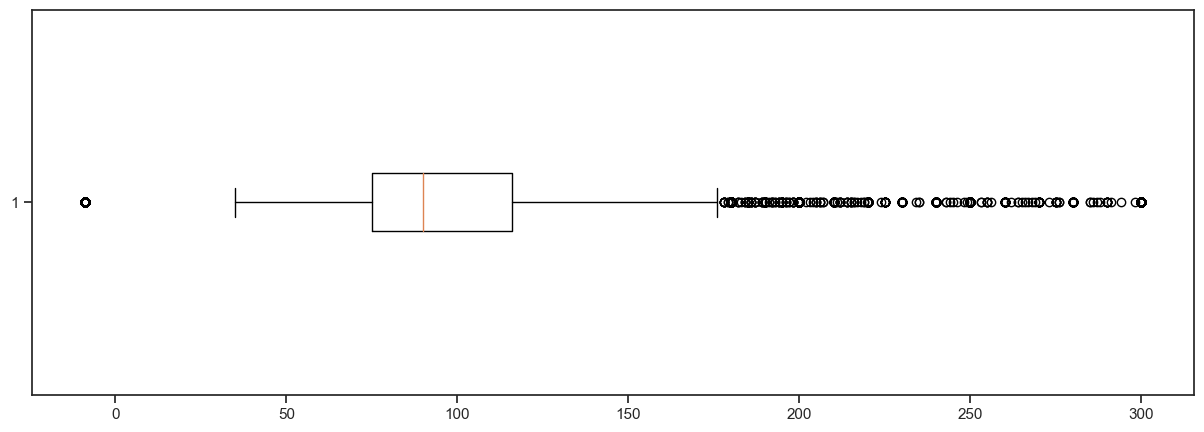

In [27]:
plt.boxplot(var20['SUPERF'],vert=False)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

As we can observe, we have -9 values for surface size, and as size cannot be negative and the number of cases with such outlier is small, we will drop the cases

In [28]:
var15 = var15[var15['SUPERF'] != -9]
var17 = var17[var17['SUPERF'] != -9]
var20 = var20[var20['SUPERF'] != -9]

We will now look at the distribution of our datasets.

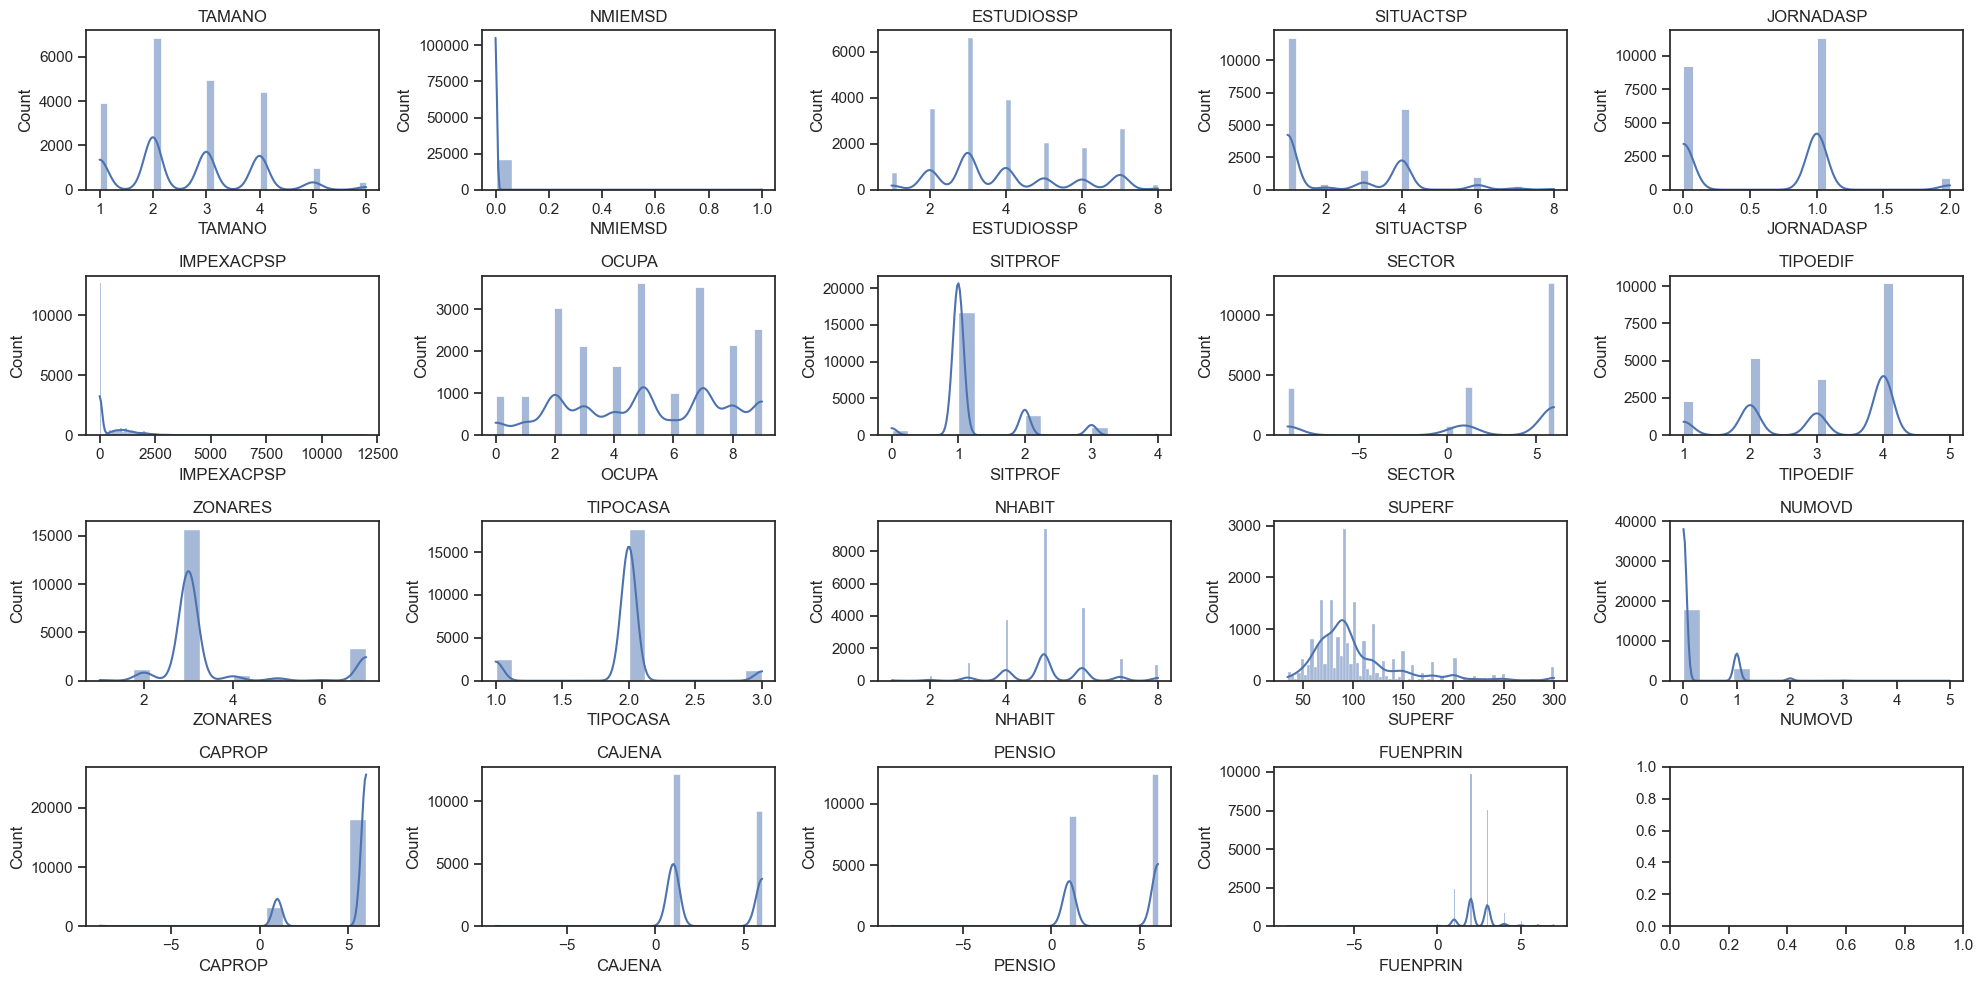

In [29]:
#2015
num_rows = 4
num_cols = 5
variable_names = list(var15.columns)
num_figures = len(variable_names)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, var_name in enumerate(variable_names):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.histplot(data=var15[var_name], ax=ax, kde=True)
    ax.set_title(var_name)
plt.tight_layout()
plt.show()

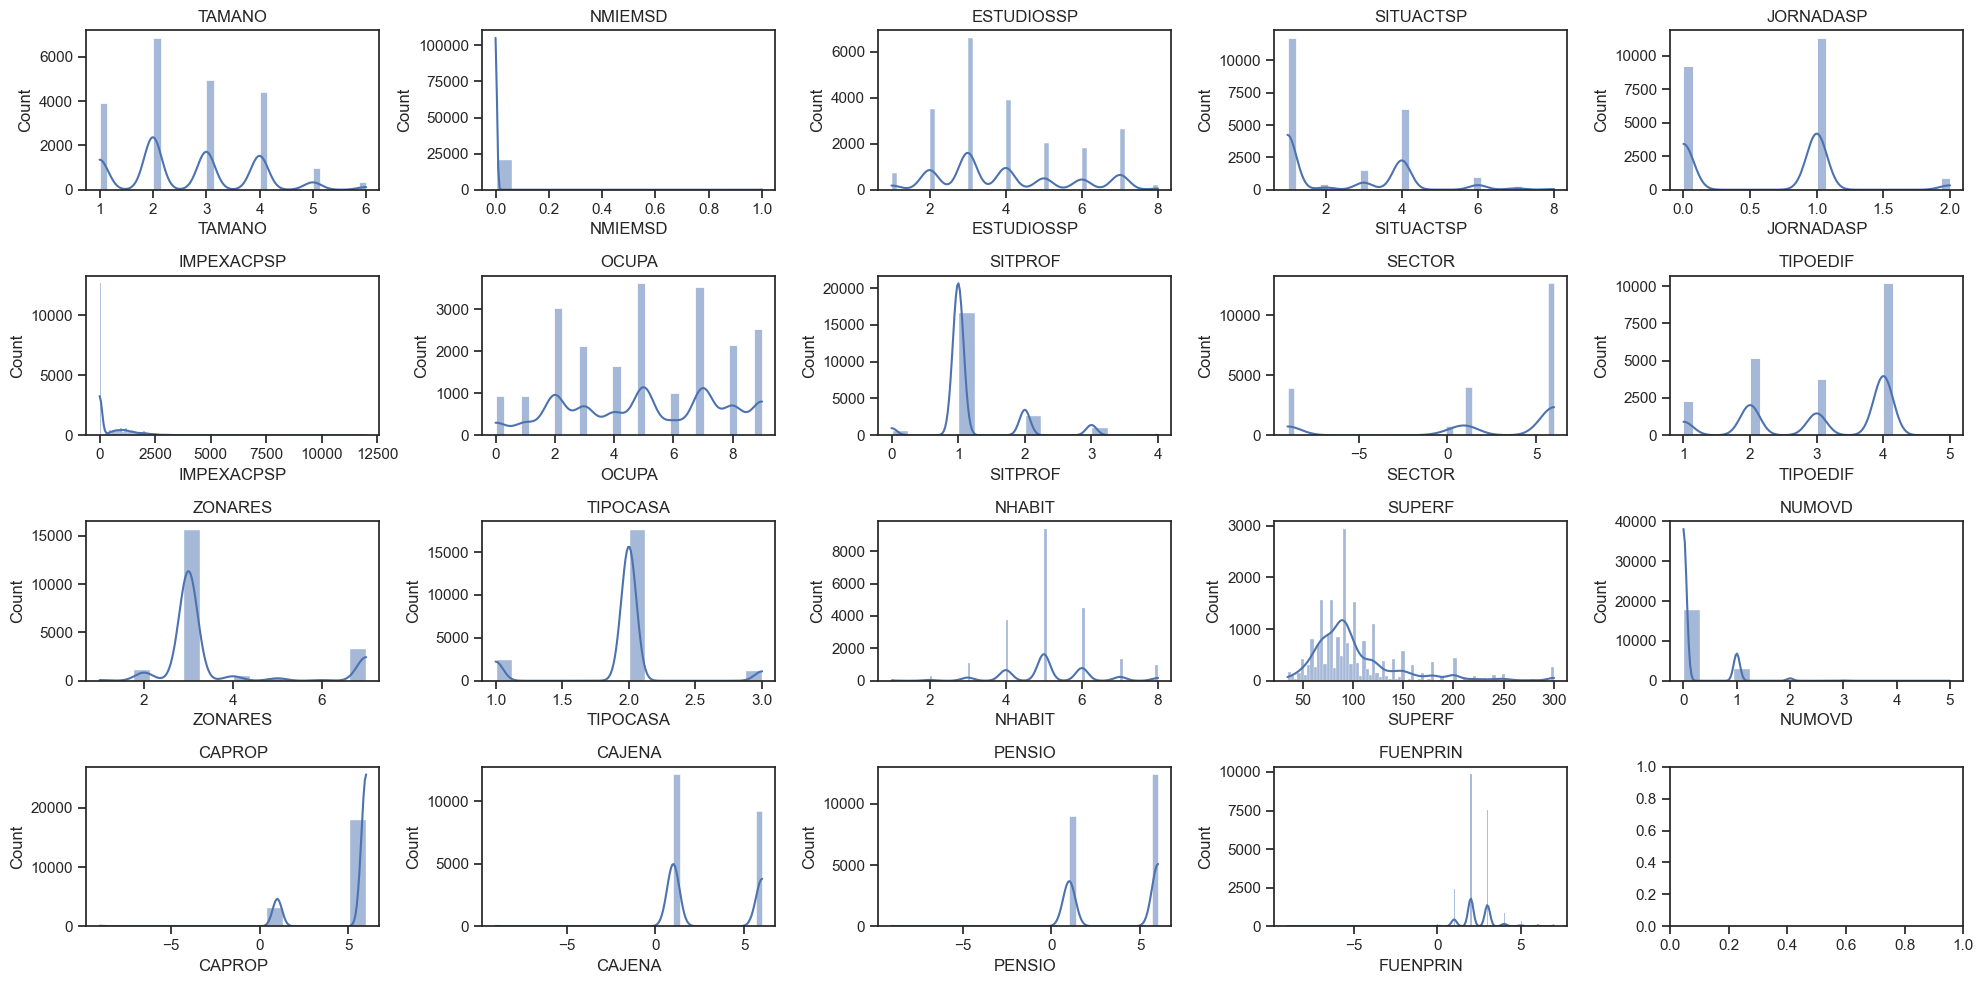

In [30]:
#2017
num_rows = 4
num_cols = 5
variable_names = list(var17.columns)
num_figures = len(variable_names)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, var_name in enumerate(variable_names):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.histplot(data=var15[var_name], ax=ax, kde=True)
    ax.set_title(var_name)
plt.tight_layout()
plt.show()

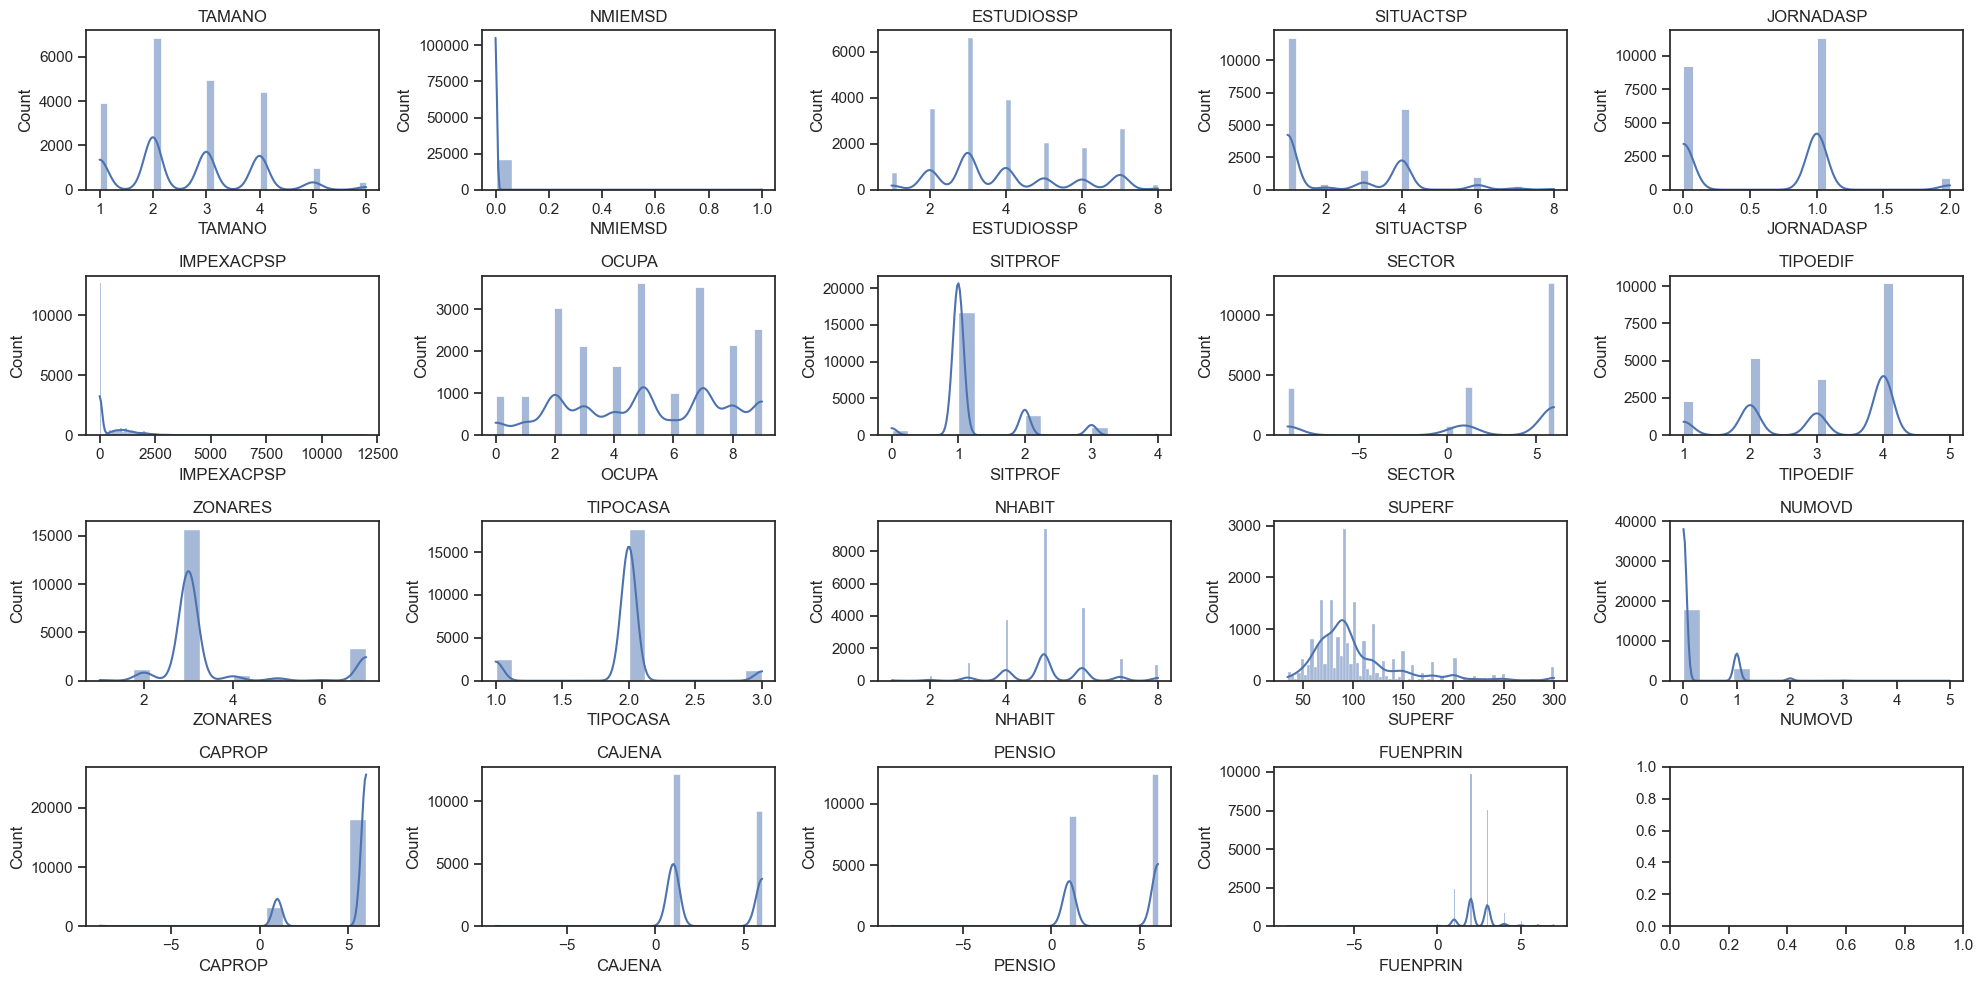

In [31]:
#2020
num_rows = 4
num_cols = 5
variable_names = list(var20.columns)
num_figures = len(variable_names)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, var_name in enumerate(variable_names):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    sns.histplot(data=var15[var_name], ax=ax, kde=True)
    ax.set_title(var_name)
plt.tight_layout()
plt.show()

## 4.Preprocessing of data
Now in order to verify that variables are on the same scale, we will standardize the datasets. This is crucial for the clustering technique we will implement--> K-means.

And using the elbow method, which plots the inertia for different k-values and shows the "elbow point", we will see why using 3 clusters is optimal

/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

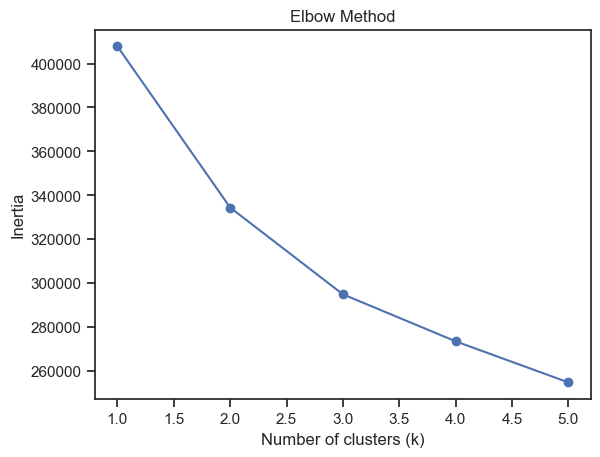

In [32]:
#2015
scaler = StandardScaler()
data_scaled_15 = scaler.fit_transform(var15)
inertia = []
k_values = list(range(1, 6))
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled_15)
    inertia.append(kmeans.inertia_)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

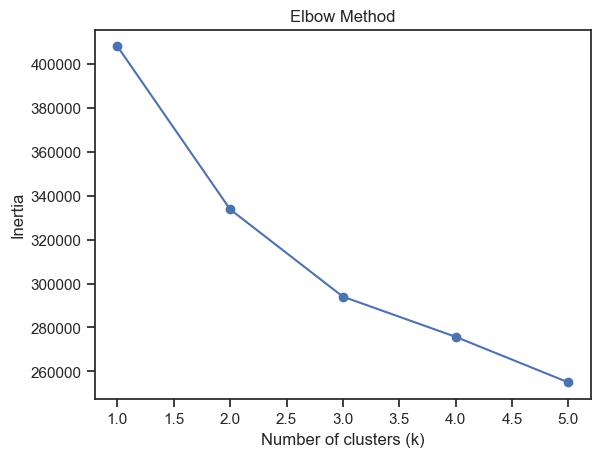

In [33]:
#2017
scaler = StandardScaler()
data_scaled_17 = scaler.fit_transform(var17)
inertia = []
k_values = list(range(1, 6))
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled_17)
    inertia.append(kmeans.inertia_)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

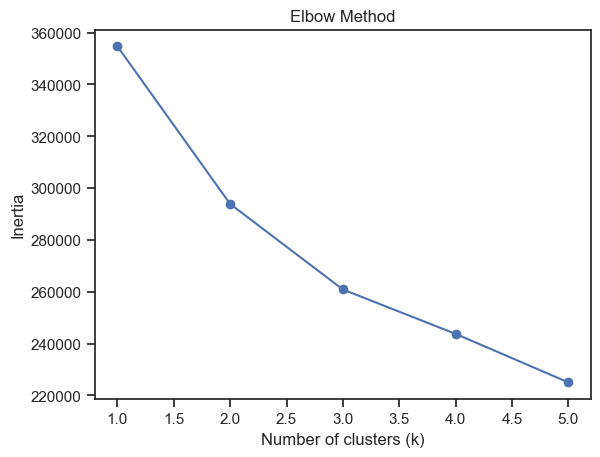

In [34]:
#2020
scaler = StandardScaler()
data_scaled_20 = scaler.fit_transform(var20)
inertia = []
k_values = list(range(1, 6))
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled_20)
    inertia.append(kmeans.inertia_)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

Now we will separately perform the clustering and check the characteristics of the clusters for each year

We will perform 3 clusters using k-means and look at the count of each of these. Then, by looking at the mean of certain variables, we will establesh which cluster is 1:lower-class, 2:middle-class and 3:upper-class.

### 2015

In [35]:
k = 3 
kmeans = KMeans(init="random",n_clusters=k,n_init=10,max_iter=300, random_state=42)
kmeans_clusters_15 = kmeans.fit_predict(data_scaled_15)

In [37]:
#Add the cluster labels to var15 and plot them against each variable
var15_clustered = var15.copy()
var15_clustered['cluster'] = kmeans_clusters_15
#sns.pairplot(var15_clustered, hue='cluster', diag_kind='hist')
#plt.show()

In [38]:
#Count of classes
var15_clustered['cluster'].value_counts()

0    9937
2    8896
1    2631
Name: cluster, dtype: int64

In [39]:
#determine what cluster represents each social class by checking the mean family income
mean_income = var15_clustered.groupby('cluster')['IMPEXACPSP'].mean()
print(mean_income)

cluster
0    595.348898
1    345.218548
2    542.614433
Name: IMPEXACPSP, dtype: float64


In [40]:
var15_clustered['cluster'] = var15_clustered['cluster'].replace({0:3, 1:1, 2:2})
var15_clustered['cluster'].value_counts()

3    9937
2    8896
1    2631
Name: cluster, dtype: int64

### 2017

In [41]:
kmeans_clusters_17 = kmeans.fit_predict(data_scaled_17)

In [42]:
#Add the cluster labels to var17 and plot them against each variable
var17_clustered = var17.copy()
var17_clustered['cluster'] = kmeans_clusters_17
#sns.pairplot(var17_clustered, hue='cluster', diag_kind='hist')
#plt.show()

In [43]:
#Count of classes
var17_clustered['cluster'].value_counts()

0    10034
2     8824
1     2622
Name: cluster, dtype: int64

In [44]:
#determine what cluster represents each social class by checking the mean family income
mean_income = var17_clustered.groupby('cluster')['IMPEXACPSP'].mean()
print(mean_income)

cluster
0    599.576041
1    365.488558
2    556.271646
Name: IMPEXACPSP, dtype: float64


In [45]:
var17_clustered['cluster'] = var17_clustered['cluster'].replace({0:3, 1:1, 2:2})
var17_clustered['cluster'].value_counts()

3    10034
2     8824
1     2622
Name: cluster, dtype: int64

### 2020

In [46]:
kmeans_clusters_20 = kmeans.fit_predict(data_scaled_20)

In [47]:
#Add the cluster labels to var20 and plot them against each variable
var20_clustered = var20.copy()
var20_clustered['cluster'] = kmeans_clusters_20
#sns.pairplot(var20_clustered, hue='cluster', diag_kind='hist')
#plt.show()

In [48]:
#Count of classes
var20_clustered['cluster'].value_counts()

1    9130
0    7444
2    2094
Name: cluster, dtype: int64

In [49]:
#determine what cluster represents each social class by checking the mean family income
mean_income = var20_clustered.groupby('cluster')['IMPEXACPSP'].mean()
print(mean_income)

cluster
0    528.694922
1    612.277766
2    355.518147
Name: IMPEXACPSP, dtype: float64


In [50]:
var20_clustered['cluster'] = var20_clustered['cluster'].replace({0:2, 1:3, 2:1})
var20_clustered['cluster'].value_counts()

3    9130
2    7444
1    2094
Name: cluster, dtype: int64

## ALL TOGETHER

In [51]:
var15_clustered["Year"] = 2015
var17_clustered["Year"] = 2017
var20_clustered["Year"] = 2020
alt = pd.concat([var15_clustered, var17_clustered, var20_clustered], ignore_index=True)
alt

,TAMANO,NMIEMSD,ESTUDIOSSP,SITUACTSP,JORNADASP,IMPEXACPSP,OCUPA,SITPROF,SECTOR,TIPOEDIF,...,TIPOCASA,NHABIT,SUPERF,NUMOVD,CAPROP,CAJENA,PENSIO,FUENPRIN,cluster,Year
0,2.0,0.0,2.0,1.0,1.0,-9.0,5.0,3.0,-9.0,2.0,...,2.0,5.0,96.0,0.0,1.0,6.0,6.0,1.0,1,2015
1,4.0,0.0,3.0,1.0,1.0,-9.0,2.0,1.0,6.0,4.0,...,2.0,6.0,155.0,0.0,6.0,1.0,6.0,2.0,3,2015
2,4.0,0.0,3.0,3.0,0.0,-9.0,6.0,1.0,6.0,2.0,...,2.0,8.0,150.0,0.0,6.0,1.0,6.0,2.0,3,2015
3,3.0,0.0,4.0,1.0,1.0,-9.0,7.0,1.0,6.0,4.0,...,2.0,5.0,98.0,0.0,6.0,1.0,6.0,2.0,3,2015
4,3.0,0.0,5.0,4.0,0.0,1750.0,3.0,1.0,6.0,4.0,...,2.0,5.0,90.0,1.0,6.0,1.0,1.0,2.0,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61607,2.0,0.0,3.0,4.0,0.0,2185.0,5.0,3.0,-9.0,3.0,...,1.0,5.0,150.0,0.0,6.0,6.0,1.0,3.0,2,2020
61608,4.0,0.0,5.0,1.0,1.0,-9.0,3.0,1.0,6.0,1.0,...,1.0,6.0,170.0,0.0,6.0,1.0,6.0,2.0,3,2020
61609,3.0,0.0,3.0,1.0,1.0,-9.0,9.0,1.0,6.0,1.0,...,2.0,5.0,90.0,0.0,1.0,1.0,6.0,1.0,3,2020
61610,1.0,0.0,2.0,4.0,0.0,1365.0,8.0,1.0,6.0,4.0,...,2.0,4.0,90.0,1.0,6.0,6.0,1.0,3.0,2,2020


## 5. Save our results

In [52]:
spain = {
    "Year": [2015, 2017, 2020],
    "Lower_Class": [2628, 2621, 2093],
    "Middle_Class": [8898, 8824, 7445],
    "High_Class": [9938, 10035, 9130],
}

spain = pd.DataFrame(spain)
spain

,Year,Lower_Class,Middle_Class,High_Class
0,2015,2628,8898,9938
1,2017,2621,8824,10035
2,2020,2093,7445,9130


Export them to a csv file

In [ ]:
spain.to_csv('/Users/mac/Desktop/TFG/data/code/classes/spain.csv', index=False)

## 6. Merge with sexual harassment cases to gain insights

In [53]:
import pandas as pd

data = {'Year': [2015, 2017, 2020],
        'Sexual_Harassment_Cases': [6823, 8018, 10798]}
sh = pd.DataFrame(data)
sh


,Year,Sexual_Harassment_Cases
0,2015,6823
1,2017,8018
2,2020,10798


In [54]:
combined = pd.merge(alt, sh, on="Year")
combined

,TAMANO,NMIEMSD,ESTUDIOSSP,SITUACTSP,JORNADASP,IMPEXACPSP,OCUPA,SITPROF,SECTOR,TIPOEDIF,...,NHABIT,SUPERF,NUMOVD,CAPROP,CAJENA,PENSIO,FUENPRIN,cluster,Year,Sexual_Harassment_Cases
0,2.0,0.0,2.0,1.0,1.0,-9.0,5.0,3.0,-9.0,2.0,...,5.0,96.0,0.0,1.0,6.0,6.0,1.0,1,2015,6823
1,4.0,0.0,3.0,1.0,1.0,-9.0,2.0,1.0,6.0,4.0,...,6.0,155.0,0.0,6.0,1.0,6.0,2.0,3,2015,6823
2,4.0,0.0,3.0,3.0,0.0,-9.0,6.0,1.0,6.0,2.0,...,8.0,150.0,0.0,6.0,1.0,6.0,2.0,3,2015,6823
3,3.0,0.0,4.0,1.0,1.0,-9.0,7.0,1.0,6.0,4.0,...,5.0,98.0,0.0,6.0,1.0,6.0,2.0,3,2015,6823
4,3.0,0.0,5.0,4.0,0.0,1750.0,3.0,1.0,6.0,4.0,...,5.0,90.0,1.0,6.0,1.0,1.0,2.0,2,2015,6823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61607,2.0,0.0,3.0,4.0,0.0,2185.0,5.0,3.0,-9.0,3.0,...,5.0,150.0,0.0,6.0,6.0,1.0,3.0,2,2020,10798
61608,4.0,0.0,5.0,1.0,1.0,-9.0,3.0,1.0,6.0,1.0,...,6.0,170.0,0.0,6.0,1.0,6.0,2.0,3,2020,10798
61609,3.0,0.0,3.0,1.0,1.0,-9.0,9.0,1.0,6.0,1.0,...,5.0,90.0,0.0,1.0,1.0,6.0,1.0,3,2020,10798
61610,1.0,0.0,2.0,4.0,0.0,1365.0,8.0,1.0,6.0,4.0,...,4.0,90.0,1.0,6.0,6.0,1.0,3.0,2,2020,10798


Lets take a closer look at each each cluster

Now we will see what variables had more importance for the cluster attribution using LASSO regression.

In [55]:
X = combined[['TAMANO','NMIEMSD','ESTUDIOSSP','SITUACTSP','JORNADASP','IMPEXACPSP','OCUPA','SITPROF','SECTOR','TIPOEDIF','ZONARES','TIPOCASA','NHABIT','SUPERF','NUMOVD','CAPROP','CAJENA','PENSIO','FUENPRIN']]
y = combined['cluster']
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)
coef = pd.Series(lasso.coef_, index=X.columns)
print("LASSO coefficients:")
print(coef.abs().sort_values())

LASSO coefficients:
TAMANO        0.000000
NUMOVD        0.000000
NHABIT        0.000000
TIPOCASA      0.000000
ZONARES       0.000000
SITPROF       0.000000
TIPOEDIF      0.000000
JORNADASP     0.000000
ESTUDIOSSP    0.000000
NMIEMSD       0.000000
FUENPRIN      0.000000
IMPEXACPSP    0.000015
SUPERF        0.000250
OCUPA         0.010762
PENSIO        0.018211
SECTOR        0.036113
SITUACTSP     0.083336
CAJENA        0.091938
CAPROP        0.154219
dtype: float64


In [56]:
time_series_data = combined.pivot_table(index="Year", columns="cluster", values="Sexual_Harassment_Cases")

for cluster in time_series_data.columns:
    model = ARIMA(time_series_data[cluster], order=(1, 1, 1))
    results = model.fit()
    print(f"Cluster {cluster}:")
    print(results.summary())
    print("Forecast for the next year:")
    print(results.forecast(steps=1))


/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users

Cluster 1:
                               SARIMAX Results                                
Dep. Variable:                      1   No. Observations:                    3
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -16.623
Date:                Thu, 04 May 2023   AIC                             39.246
Time:                        11:37:44   BIC                             35.325
Sample:                             0   HQIC                            31.047
                                  - 3                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.042     23.605      0.000       0.917       1.083
ma.L1         -0.9981     19.672     -0.051      0.960     -39.555      37.559
sigma2      7.544e+05   3.39e-08   2.23e+

/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1327: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1339: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  warnings.warn(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mac/opt/miniconda3/envs/tfg/lib/python3.10/site

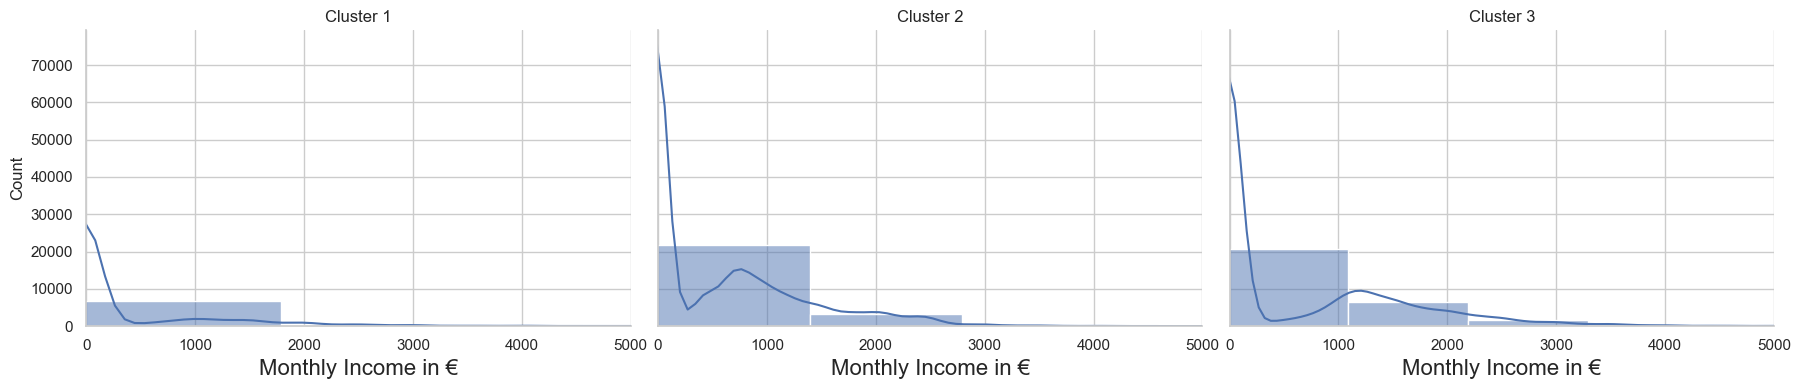

In [68]:
sns.set(style="whitegrid")
long_format_data = combined.melt(id_vars=['cluster'], value_vars=['IMPEXACPSP'])
g = sns.FacetGrid(long_format_data, col='cluster', row='variable', sharey='row', sharex='col', height=4, aspect=1.5)
g.map(sns.histplot, 'value', kde=True, bins=10)
g.set_titles("Cluster {col_name}")
g.set(xlim=(0, 5000))
g.set_xlabels('Monthly Income in €',fontsize=16)
plt.subplots_adjust(wspace=0.05)
plt.show()

In [58]:
#CAPROP --> Ingresos de trabajo por cuenta propia 1 Sí 6 No
grouped=combined.groupby('cluster')['SECTOR'].value_counts()
grouped

cluster  SECTOR
1        -9.0       7017
          6.0        170
          1.0        159
          0.0          1
2         6.0      15020
          1.0       4113
         -9.0       3910
          0.0       2121
3         6.0      21161
          1.0       7919
         -9.0         18
          0.0          3
Name: SECTOR, dtype: int64

Lets make. avisual represantation of the different classes and sectors

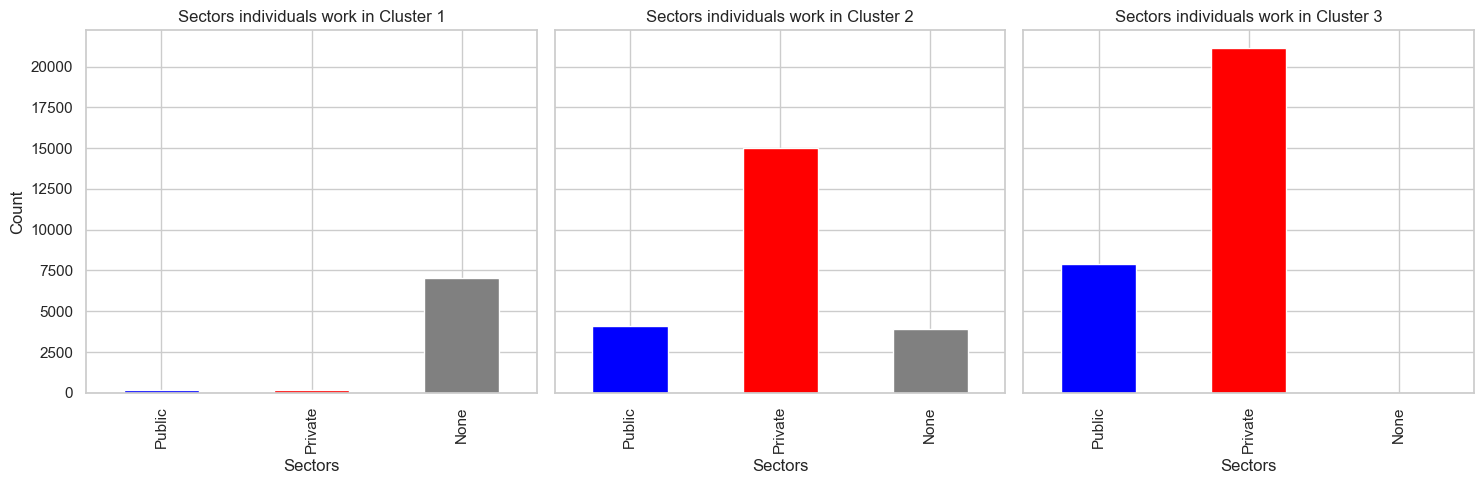

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i in range(1, 4):
    cluster_data = combined[combined['cluster'] == i]
    sector_counts = cluster_data['SECTOR'].value_counts()
    #rename variable
    selected_values = sector_counts.loc[[1, 6, -9]]
    selected_values.index = ['Public', 'Private', 'None']
    #select colours
    selected_values.plot(kind='bar', ax=axes[i-1], color=['blue', 'red', 'grey'])
    axes[i-1].set_title(f'Sectors individuals work in Cluster {i}')
    axes[i-1].set_xlabel('Sectors')
    axes[i-1].set_ylabel('Count')
plt.tight_layout()
plt.show()